<a href="https://colab.research.google.com/github/jrangelg/Artificial-intelligence/blob/main/Simulaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simular ecuaciones diferenciales estocásticas.

In [1]:
import numpy as np
import pandas as pd

# ==============================
# Utilidades de estimación fBM
# ==============================

def estimate_mu_H_sigma_from_logprice(logp: pd.Series, max_lag: int = 10):
    """
    Estima (mu, H, sigma) en L_t = mu*t + sigma * B^H_t sobre datos diarios.
    - mu: media de los incrementos diarios de log-precio
    - H, sigma: por variograma log–log de incrementos k-pasos (k=1..max_lag)

    Parámetros
    ----------
    logp : pd.Series (indexado por fecha, frecuencia diaria hábil)
    max_lag : int, máximo k para el variograma (por defecto 10)

    Retorna
    -------
    mu_hat, H_hat, sigma_hat
    """
    # t equiespaciado implícito (1 = 1 día hábil)
    dL = logp.diff().dropna()
    mu_hat = dL.mean()  # deriva diaria media

    # Variograma de incrementos k-pasos, quitando la deriva k*mu
    ks = np.arange(1, max_lag + 1, dtype=int)
    var_k = []
    for k in ks:
        inc_k = (logp.shift(-k) - logp)  # L_{t+k} - L_t
        inc_k = inc_k.dropna() - mu_hat * k
        var_k.append(np.var(inc_k.values, ddof=1))

    var_k = np.array(var_k)
    # Evitar problemas numéricos
    mask = (var_k > 0)
    ks_fit = ks[mask]
    var_k_fit = var_k[mask]

    # Regresión: log Var(Δ_k) = log(σ^2) + 2H * log k
    X = np.log(ks_fit).reshape(-1, 1)
    y = np.log(var_k_fit).reshape(-1, 1)
    # OLS con término independiente
    X_design = np.column_stack([np.ones_like(X), X])
    beta = np.linalg.lstsq(X_design, y, rcond=None)[0].ravel()
    intercept, slope = beta[0], beta[1]
    H_hat = float(slope / 2.0)
    sigma_hat = float(np.exp(intercept / 2.0))

    # Acotar H a (0,1) por estabilidad numérica
    H_hat = min(max(H_hat, 1e-3), 0.999)

    return float(mu_hat), H_hat, sigma_hat


def fgn_covariance(H: float, n: int):
    """
    Matriz de covarianza (n x n) para fGn (incrementos de fBM) a paso 1.
    γ(k) = 0.5[(|k+1|^{2H} - 2|k|^{2H} + |k-1|^{2H})]
    """
    k = np.arange(n, dtype=float)
    gamma = 0.5 * ((np.abs(k + 1.0)**(2*H)) - 2.0*(np.abs(k)**(2*H)) + (np.abs(k - 1.0)**(2*H)))
    # Construye Toeplitz
    cov = np.empty((n, n), dtype=float)
    for i in range(n):
        cov[i, :] = gamma[np.abs(np.arange(n) - i)]
    return cov


def simulate_fbm_paths(mu: float, H: float, sigma: float, L0: float,
                       n_steps: int, n_paths: int = 100, random_state: int | None = None):
    """
    Simula trayectorias futuras de log-precio bajo L_{t+1} = L_t + mu + sigma * ΔB_t^H
    donde ΔB_t^H ~ fGn(H), covarianza consistente con fBM a paso 1.

    Retorna
    -------
    L_paths : np.ndarray (n_paths, n_steps+1) log-precios incluyendo el valor inicial L0
    S_paths : np.ndarray (n_paths, n_steps+1) precios (exp(L))
    """
    rng = np.random.default_rng(random_state)

    # Covarianza de los incrementos fGn a paso 1
    cov = fgn_covariance(H, n_steps)
    # Cholesky estable (si falla, añade jitter)
    jitter = 0
    for _attempt in range(3):
        try:
            L = np.linalg.cholesky(cov + jitter * np.eye(n_steps))
            break
        except np.linalg.LinAlgError:
            jitter = 1e-10 if jitter == 0 else jitter * 10
    else:
        # Último recurso: eigen (más caro)
        eigvals, eigvecs = np.linalg.eigh(cov)
        eigvals = np.clip(eigvals, 0, None)
        L = eigvecs @ np.diag(np.sqrt(eigvals)) @ eigvecs.T

    # Simula incrementos para todos los paths
    Z = rng.standard_normal(size=(n_paths, n_steps))
    fgn_increments = Z @ L.T  # (n_paths, n_steps)

    # Construye log-precio
    L_paths = np.empty((n_paths, n_steps + 1), dtype=float)
    L_paths[:, 0] = L0
    # μ y σ se aplican por paso (1 día hábil)
    L_paths[:, 1:] = L0 + np.cumsum(mu + sigma * fgn_increments, axis=1)

    S_paths = np.exp(L_paths)
    return L_paths, S_paths


# =====================================
# Pipeline completo con datos del activo
# =====================================

def prepare_last_year(prices: pd.Series) -> pd.Series:
    """Devuelve último año (≈252 ruedas) con índice limpio y sin NaN."""
    prices = prices.dropna().astype(float).sort_index()
    if prices.index.inferred_type not in ("datetime64", "datetime"):
        prices.index = pd.to_datetime(prices.index)
    # 252 ruedas ~ 1 año
    last_year = prices.iloc[-252:] if len(prices) > 252 else prices.copy()
    return last_year


def fit_and_simulate(prices: pd.Series,
                     n_future_days: int = 60,
                     n_paths: int = 100,
                     start_in_days: int = 10,
                     random_state: int | None = 42):
    """
    - Usa el último año de 'prices'
    - Estima (mu, H, sigma) en log-precio
    - Simula 'n_paths' trayectorias futuras por 'n_future_days'
    - Entrega además un recorte que empieza en 'start_in_days' (p.ej., 10 ~ dos semanas)

    Retorna
    -------
    results : dict con:
        'mu', 'H', 'sigma'
        'L0', 'S0'
        'future_dates' : DatetimeIndex de longitud n_future_days
        'L_paths', 'S_paths' : arrays completos (n_paths, n_future_days+1)
        'L_paths_from_two_weeks', 'S_paths_from_two_weeks' : recortes desde start_in_days
    """
    last_year = prepare_last_year(prices)
    logp = np.log(last_year)
    # Estimación
    mu_hat, H_hat, sigma_hat = estimate_mu_H_sigma_from_logprice(logp)

    # Punto de partida
    L0 = float(np.log(last_year.iloc[-1]))
    S0 = float(last_year.iloc[-1])

    # Fechas futuras (asumiendo días hábiles contiguos como índice + 1..n_future_days)
    # Si tu serie es estrictamente hábil, usa BDay en vez de Day:
    future_dates = pd.bdate_range(last_year.index[-1] + pd.tseries.offsets.BDay(1),
                                  periods=n_future_days)

    # Simulación
    L_paths, S_paths = simulate_fbm_paths(mu_hat, H_hat, sigma_hat, L0,
                                          n_steps=n_future_days,
                                          n_paths=n_paths,
                                          random_state=random_state)

    # Recorte a partir de dos semanas (start_in_days)
    start = int(start_in_days)
    start = min(max(start, 0), n_future_days)  # bounds
    L_paths_2w = L_paths[:, start:]
    S_paths_2w = S_paths[:, start:]
    future_dates_2w = future_dates[start-1:] if start > 0 else future_dates

    return {
        "mu": mu_hat, "H": H_hat, "sigma": sigma_hat,
        "L0": L0, "S0": S0,
        "future_dates": future_dates,
        "L_paths": L_paths, "S_paths": S_paths,
        "future_dates_from_two_weeks": future_dates_2w,
        "L_paths_from_two_weeks": L_paths_2w,
        "S_paths_from_two_weeks": S_paths_2w,
    }


# =====================================
# Ejemplo de uso con yfinance (opcional)
# =====================================
if __name__ == "__main__":
    # Opción A: si ya tienes un pd.Series de precios, úsalo:
    # prices = tu_serie  # index DatetimeIndex, values float

    # Opción B: descargar con yfinance (requiere: pip install yfinance)
    try:
        import yfinance as yf
        ticker = "AAPL"        # <-- cambia por tu activo (p.ej. "EC" para Ecopetrol, "NVDA", etc.)
        df = yf.download(ticker, period="2y", interval="1d", auto_adjust=True, progress=False)
        prices = df["Close"].dropna()
    except Exception as e:
        raise SystemExit(
            f"No pude descargar datos con yfinance ({e}). "
            "Pasa tu propia serie de precios como pd.Series para continuar."
        )

    results = fit_and_simulate(prices, n_future_days=60, n_paths=100, start_in_days=10, random_state=123)

    print("Parámetros estimados (último año):")
    print(f"  mu (deriva diaria)    = {results['mu']:.6f}")
    print(f"  H  (Hurst)            = {results['H']:.4f}")
    print(f"  sigma (escala fBM)    = {results['sigma']:.6f}")
    print(f"  Precio actual S0      = {results['S0']:.4f}")

    # Ejemplo: percentiles al final del horizonte (día 60)
    S_end = results["S_paths"][:, -1]
    p5, p50, p95 = np.percentile(S_end, [5, 50, 95])
    print("\nDistribución del precio al final del horizonte (día 60) - percentiles:")
    print(f"  P5 = {p5:.4f}, Mediana = {p50:.4f}, P95 = {p95:.4f}")

    # Si quieres graficar (opcional):
    # import matplotlib.pyplot as plt
    # t = np.arange(results["S_paths"].shape[1])
    # plt.plot(t, results["S_paths"].T, alpha=0.2)
    # plt.title(f"Trayectorias simuladas fBM ({ticker}) - 100 paths")
    # plt.xlabel("Días hábiles adelante")
    # plt.ylabel("Precio")
    # plt.show()


Parámetros estimados (último año):
  mu (deriva diaria)    = 0.000533
  H  (Hurst)            = 0.4717
  sigma (escala fBM)    = 0.021386
  Precio actual S0      = 258.0200

Distribución del precio al final del horizonte (día 60) - percentiles:
  P5 = 215.0286, Mediana = 273.3375, P95 = 333.2622


/tmp/ipython-input-2581716056.py:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(mu_hat), H_hat, sigma_hat
/tmp/ipython-input-2581716056.py:154: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  L0 = float(np.log(last_year.iloc[-1]))
/tmp/ipython-input-2581716056.py:155: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(last_year.iloc[-1])


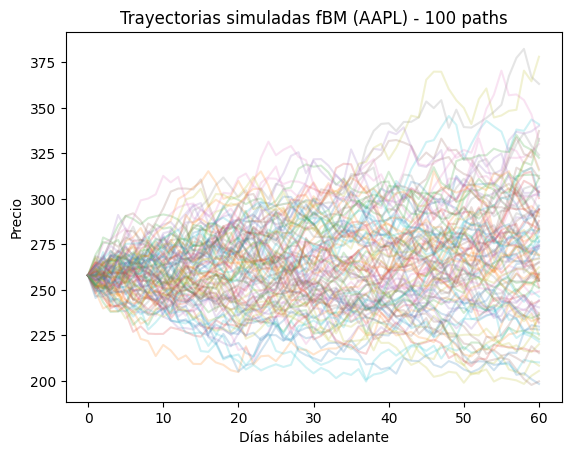

In [6]:
    #Si quieres graficar (opcional):
import matplotlib.pyplot as plt
t = np.arange(results["S_paths"].shape[1])
plt.plot(t, results["S_paths"].T, alpha=0.2)
plt.title(f"Trayectorias simuladas fBM ({ticker}) - 100 paths")
plt.xlabel("Días hábiles adelante")
plt.ylabel("Precio")
plt.show()

In [7]:
import numpy as np

# ============================================================
# Utilidades de covarianzas y tiempos para fBM y puente fBM
# ============================================================

def fbm_cov_times(H: float, times: np.ndarray) -> np.ndarray:
    """
    Matriz de covarianza Cov(B^H(t_i), B^H(t_j)) para un fBM estándar (Var B^H(1)=1),
    con tiempos 'times' en [0,T], usando:
        Cov(t,s) = 0.5*( t^{2H} + s^{2H} - |t-s|^{2H} )
    """
    t = times.reshape(-1, 1)
    s = times.reshape(1, -1)
    return 0.5 * (np.power(t, 2*H) + np.power(s, 2*H) - np.power(np.abs(t - s), 2*H))


def fbm_bridge_conditional(H: float, times: np.ndarray, T: float,
                           yT: float, mu: float = 0.0, x0: float = 0.0, sigma: float = 1.0):
    """
    Calcula media y covarianza condicionales para el vector X(times) dado X(T)=yT,
    bajo X(t) = x0 + mu*t + sigma*B^H(t), con B^H fBM estándar independiente.

    Retorna
    -------
    mean_cond : (n_times,) media condicional
    cov_cond  : (n_times, n_times) covarianza condicional
    """
    # Vector de tiempos (excluye 0 si no quieres incluir X(0))
    times = np.asarray(times, dtype=float)
    n = len(times)

    # Media no condicionada
    m_vec = x0 + mu * times  # E[X(t)]
    m_T  = x0 + mu * T       # E[X(T)]

    # Covarianzas base de fBM (estándar), luego escalamos por sigma^2
    K_tt = fbm_cov_times(H, times)               # Cov(B(times), B(times))
    K_tT = 0.5 * (times**(2*H) + T**(2*H) - np.abs(T - times)**(2*H))  # Cov(B(times), B(T)) -> (n,)
    var_T = T**(2*H)                              # Var(B(T))

    # Escalamiento por sigma
    K_tt *= sigma**2
    K_tT = (sigma**2) * K_tT
    var_T = (sigma**2) * var_T

    # Condicional Gaussiano: X_t | X_T = yT
    # media: m_t + Cov(t,T) * Var(T)^{-1} * (yT - m_T)
    # cov:   Cov(t,t) - Cov(t,T) * Var(T)^{-1} * Cov(T,t)
    diff = yT - m_T
    gain = K_tT / var_T  # (n,)
    mean_cond = m_vec + gain * diff
    cov_cond  = K_tt - np.outer(gain, gain) * var_T

    # Corrección numérica (simetría + PSD suave)
    cov_cond = 0.5 * (cov_cond + cov_cond.T)
    # jitter mínimo si hace falta para Cholesky
    return mean_cond, cov_cond


def sample_gaussian(mean: np.ndarray, cov: np.ndarray, n_paths: int, rng=None) -> np.ndarray:
    """
    Muestra n_paths vectores ~ N(mean, cov). Devuelve array (n_paths, len(mean)).
    Usa Cholesky con jitter si es necesario.
    """
    rng = np.random.default_rng() if rng is None else rng
    n = len(mean)
    jitter = 0.0
    for _ in range(4):
        try:
            L = np.linalg.cholesky(cov + jitter * np.eye(n))
            break
        except np.linalg.LinAlgError:
            jitter = 1e-12 if jitter == 0.0 else jitter * 10
    else:
        # último recurso: descomposición espectral
        w, V = np.linalg.eigh(cov)
        w = np.clip(w, 0.0, None)
        L = V @ np.diag(np.sqrt(w)) @ V.T
    Z = rng.standard_normal((n_paths, n))
    return mean + Z @ L.T


# ============================================================
# Puente fBM MULTIVARIANTE (componentes independientes)
# ============================================================

def simulate_mfbm_bridge_independent(
    H_list, mu_vec, sigma_vec, x0_vec, yT_vec,
    T: float = 1.0, n_steps: int = 50, n_paths: int = 100, include_T: bool = True, random_state: int | None = 123
):
    """
    Simula un PUENTE fBM multivariante de dimensión d con Hurst por componente (independientes).
    Condiciona a X(T) = yT_vec.

    Parámetros
    ----------
    H_list     : lista/array de H_i en (0,1) por componente (d,)
    mu_vec     : deriva por componente (d,)
    sigma_vec  : escala por componente (d,)
    x0_vec     : valor inicial X(0) por componente (d,)
    yT_vec     : valor final objetivo X(T) por componente (d,)
    T          : horizonte final del puente
    n_steps    : número de divisiones del intervalo [0,T] (tiempos equiespaciados)
    n_paths    : cantidad de trayectorias a simular
    include_T  : si True, devuelve también el punto en T (será exactamente yT_vec)
    random_state: seed

    Retorna
    -------
    times : (m,) tiempos (con o sin T)
    X     : array de forma (n_paths, m, d) con las trayectorias
    """
    rng = np.random.default_rng(random_state)
    H_list   = np.asarray(H_list, dtype=float)
    mu_vec   = np.asarray(mu_vec, dtype=float)
    sigma_vec= np.asarray(sigma_vec, dtype=float)
    x0_vec   = np.asarray(x0_vec, dtype=float)
    yT_vec   = np.asarray(yT_vec, dtype=float)
    d = len(H_list)
    assert d == len(mu_vec) == len(sigma_vec) == len(x0_vec) == len(yT_vec)

    # tiempos intermedios (excluimos 0; el 0 lo agregamos manualmente)
    times_full = np.linspace(0.0, T, n_steps + 1)  # 0, ..., T
    times_mid  = times_full[1:-1]                  # quitamos 0 y T
    m = len(times_mid)

    # inicializamos array de salida (sin 0 ni T por ahora)
    X_mid = np.zeros((n_paths, m, d))

    # simula por componente, condicionando a X_i(T)=yT_i
    for i in range(d):
        H   = float(H_list[i])
        mu  = float(mu_vec[i])
        sig = float(sigma_vec[i])
        x0  = float(x0_vec[i])
        yT  = float(yT_vec[i])

        if m > 0:
            mean_cond, cov_cond = fbm_bridge_conditional(
                H=H, times=times_mid, T=T, yT=yT, mu=mu, x0=x0, sigma=sig
            )
            # muestro n_paths vectores (dim m)
            X_mid[:, :, i] = sample_gaussian(mean_cond, cov_cond, n_paths, rng=rng)
        # si m==0, no hay puntos intermedios

    # Construimos trayectoria completa incluyendo t=0 y opcionalmente T
    if m > 0:
        # concatenamos X(0) y X(T)
        X0 = np.broadcast_to(x0_vec, (n_paths, 1, d))
        if include_T:
            XT = np.broadcast_to(yT_vec, (n_paths, 1, d))
            X = np.concatenate([X0, X_mid, XT], axis=1)
            times = times_full
        else:
            X = np.concatenate([X0, X_mid], axis=1)
            times = times_full[:-1]
    else:
        # solo extremos
        X0 = np.broadcast_to(x0_vec, (n_paths, 1, d))
        if include_T:
            XT = np.broadcast_to(yT_vec, (n_paths, 1, d))
            X = np.concatenate([X0, XT], axis=1)
            times = np.array([0.0, T])
        else:
            X = X0
            times = np.array([0.0])

    return times, X


# ============================================================
# Puente entre dos puntos: condicionar en t0 y T (opcional)
# ============================================================

def simulate_mfbm_bridge_two_point_independent(
    H_list, mu_vec, sigma_vec, x0_vec, t0_vals_vec, yT_vec,
    t0: float, T: float, n_steps_between: int = 50, n_paths: int = 100, include_ends: bool = True, random_state: int | None = 123
):
    """
    Variante: condiciona a X(t0)=t0_vals_vec y X(T)=yT_vec. Útil si ya observaste el estado a mitad de camino
    (por ejemplo, “dos semanas”) y quieres puentear hasta T.

    Retorna tiempos y trayectorias en (t0, ..., T) (y opcionalmente incluye 0 y t0 también si lo deseas).
    """
    rng = np.random.default_rng(random_state)
    H_list   = np.asarray(H_list, dtype=float)
    mu_vec   = np.asarray(mu_vec, dtype=float)
    sigma_vec= np.asarray(sigma_vec, dtype=float)
    x0_vec   = np.asarray(x0_vec, dtype=float)
    t0_vals_vec = np.asarray(t0_vals_vec, dtype=float)
    yT_vec   = np.asarray(yT_vec, dtype=float)
    d = len(H_list)
    assert d == len(mu_vec) == len(sigma_vec) == len(x0_vec) == len(t0_vals_vec) == len(yT_vec)

    # tiempos entre t0 y T (excluye los extremos)
    times_seg = np.linspace(t0, T, n_steps_between + 1)  # t0, ..., T
    times_mid = times_seg[1:-1]
    m = len(times_mid)

    X_mid = np.zeros((n_paths, m, d))

    for i in range(d):
        H   = float(H_list[i]); mu = float(mu_vec[i]); sig=float(sigma_vec[i])
        x0  = float(x0_vec[i]);  xt0=float(t0_vals_vec[i]); yT=float(yT_vec[i])

        # Re-centramos proceso: Y(t)=X(t)-mu*t, Y(0)=x0, Y(t0)=xt0-mu*t0, Y(T)=yT-mu*T
        # Y es fBM con escala sigma y media 0.
        # Condicionamos Y(times_mid) a Y(t0)=y0 y Y(T)=yT0.
        y0  = xt0 - (x0 + mu*t0)  # esto sería el "puente" relativo si fijáramos X(0)=x0 fijo
        # Pero más limpio: trabajamos con el fBM puro y luego sumamos x0 + mu*t
        # Así, para el fBM puro con B(0)=0, queremos B(t0)=b0 y B(T)=bT, donde:
        b0 = (xt0 - (x0 + mu*t0)) / sig
        bT = (yT  - (x0 + mu*T )) / sig

        # Construimos el vector conjunto [B(t0), B(times_mid), B(T)] y condicionamos en (B(t0)=b0, B(T)=bT)
        # Para eficiencia hacemos condicional en dos pasos: primero condicionar en B(T)=bT y luego en B(t0)=b0
        # (ambos son escalares, así que es barato).

        # Paso 1: condicionar en T
        if m > 0:
            mean1, cov1 = fbm_bridge_conditional(H, times=np.concatenate(([t0], times_mid)), T=T, yT=bT, mu=0.0, x0=0.0, sigma=1.0)
            # mean1[0] y cov1[0,0] son para t0
            m_t0, v_t0 = mean1[0], cov1[0,0]
            # Condicionar ahora en B(t0)=b0 (gaussiano escalar)
            # Para el resto (times_mid):
            mean_mid = mean1[1:] + cov1[1:, [0]].flatten() * (b0 - m_t0) / v_t0
            cov_mid  = cov1[1:, 1:] - np.outer(cov1[1:, 0], cov1[0, 1:]) / v_t0
        else:
            # si no hay puntos intermedios entre t0 y T, no hay nada que simular
            mean_mid = np.zeros((0,))
            cov_mid  = np.zeros((0,0))

        # muestreamos B(times_mid) | B(t0)=b0, B(T)=bT
        if m > 0:
            B_mid = sample_gaussian(mean_mid, cov_mid, n_paths, rng=rng)  # (n_paths, m)
        else:
            B_mid = np.zeros((n_paths, 0))

        # Reconstruimos X(times_mid) = x0 + mu*times_mid + sigma * B(times_mid)
        if m > 0:
            X_mid[:, :, i] = (x0 + mu * times_mid) + sig * B_mid

    # Armamos salida
    if m > 0:
        # incluimos extremos si se pide
        if include_ends:
            times = np.concatenate(([0.0, t0], times_mid, [T]))
            X = np.zeros((n_paths, len(times), d))
            # X(0) = x0
            X[:, 0, :] = np.broadcast_to(x0_vec, (n_paths, d))
            # X(t0) = t0_vals_vec
            X[:, 1, :] = np.broadcast_to(t0_vals_vec, (n_paths, d))
            # tramo medio
            X[:, 2:-1, :] = X_mid
            # X(T) = yT_vec
            X[:, -1, :] = np.broadcast_to(yT_vec, (n_paths, d))
        else:
            times = np.concatenate((times_mid,))
            X = X_mid
    else:
        # solo extremos
        times = np.array([t0, T]) if include_ends else np.array([])
        if include_ends:
            X = np.zeros((n_paths, 2, d))
            X[:, 0, :] = np.broadcast_to(t0_vals_vec, (n_paths, d))
            X[:, 1, :] = np.broadcast_to(yT_vec, (n_paths, d))
        else:
            X = np.zeros((n_paths, 0, d))

    return times, X


# ============================================================
# (OPCIONAL) Correlación aproximada entre componentes
# ============================================================

def correlate_components_separable(X: np.ndarray, corr: np.ndarray, rng=None) -> np.ndarray:
    """
    TRUCO opcional (aproximación):
    - Dado X ~ N(mean, blockdiag(S_1, ..., S_d)) (independencia entre componentes),
      inducimos correlación 'corr' entre componentes aplicando una mezcla lineal
      separable en componentes (misma mezcla para todos los tiempos).
    - NO preserva exactamente todas las covarianzas cruzadas de un verdadero mfBM,
      pero sirve como aproximación rápida cuando los H_i difieren.

    X: (n_paths, m, d)
    corr: (d,d) simétrica PSD con diag=1
    """
    rng = np.random.default_rng() if rng is None else rng
    d = X.shape[2]
    # Cholesky de la correlación
    jitter = 0.0
    for _ in range(4):
        try:
            C = np.linalg.cholesky(corr + jitter * np.eye(d))
            break
        except np.linalg.LinAlgError:
            jitter = 1e-12 if jitter == 0.0 else jitter * 10
    else:
        w, V = np.linalg.eigh(corr)
        w = np.clip(w, 0.0, None)
        C = V @ np.diag(np.sqrt(w)) @ V.T

    # Centramos por trayectoria-tiempo, aplicamos mezcla lineal en el eje de componentes
    # (Si X ya está centrado/estandarizado por componente, mejor aún; aquí lo aplicamos directamente)
    X_shape = X.shape
    X2 = X.reshape(X_shape[0]*X_shape[1], d) @ C.T
    return X2.reshape(X_shape)


# ============================================================
# EJEMPLO DE USO
# ============================================================
if __name__ == "__main__":
    # Dimensión y parámetros
    H_list    = [0.70, 0.55, 0.85]        # Hurst por componente (diferentes)
    mu_vec    = [0.0005, 0.0002, -0.0001] # derivadas (por unidad de tiempo)
    sigma_vec = [0.02, 0.015, 0.03]       # escalas
    x0_vec    = [4.0, 5.2, 3.5]           # X(0) (p.ej. log-precios iniciales)
    T         = 1.0
    n_steps   = 60
    n_paths   = 100

    # Objetivo final para el puente (p.ej., log-precios al final)
    yT_vec    = [4.1, 5.15, 3.6]

    # Simulamos puente multivariante (componentes independientes)
    times, X = simulate_mfbm_bridge_independent(
        H_list, mu_vec, sigma_vec, x0_vec, yT_vec,
        T=T, n_steps=n_steps, n_paths=n_paths, include_T=True, random_state=2025
    )

    print("Tiempos:", times.shape, " -> desde", times[0], "hasta", times[-1])
    print("Trayectorias X shape:", X.shape, " (n_paths, n_times, dim)")

    # (Opcional) inducir correlación aproximada entre componentes:
    # corr_target = np.array([[1.0, 0.5, 0.2],
    #                         [0.5, 1.0, 0.1],
    #                         [0.2, 0.1, 1.0]])
    # X_corr = correlate_components_separable(X, corr=corr_target)

    # Si quieres precios: S = exp(X)
    # S = np.exp(X)


Tiempos: (61,)  -> desde 0.0 hasta 1.0
Trayectorias X shape: (100, 61, 3)  (n_paths, n_times, dim)
